In [39]:
from scipy import signal
import matplotlib.pyplot as plt
from numpy import *
import numpy as np
from scipy.io.wavfile import write, read
import control
import os
from scipy.fftpack import fft, dct
from scipy.cluster.vq import vq, kmeans, whiten
from python_speech_features import mfcc #To compare
from sklearn.metrics import confusion_matrix
import seaborn as sns
import random

from IPython import display

In [2]:
def pre_emphasis(x, alpha):
    y=np.zeros((x.size,))
    y[0]=x[0]
    for i in range(1,x.size):
        y[i]=x[i]-alpha*x[i-1]
    return y

def get_STE(signal, nFrames, sampsPerFrame):
    STEs = []  # list of short-time energies
    for k in range(nFrames):
        startIdx = k*sampsPerFrame
        stopIdx = startIdx + sampsPerFrame
        window = zeros(signal.shape)
        window[startIdx:stopIdx] = np.hamming(sampsPerFrame)  # Hamming window
        STE = sum((signal**2)*(window**2))
        STEs.append(STE)
    return STEs

def end_pointer(signal, STEs, n):
    folder='./cut_gender_separated_data/Female/'
    digits = ['0','0','1','1','2','2','3','3','4','4','5','5',
             '6','6','7','7','8','8','9','9']
    width_phone = 18  #For simplicity fix length of all phones 
    frame=8  #Start analysis from this frame
    count=0
    while(frame<len(STEs)):
        if(STEs[frame]>=0.5):  #When over a threshold 
            sound=signal1[(frame-2)*sampsPerFrame:(frame+width_phone)*sampsPerFrame]  #Extract signal of width 20 frames
            write(folder + digits[count] + '/digit_{}_{}_{}.wav'.format(digits[count], n, count%2), 8000, sound)
            frame+=27  #Skip certain amount onto further analysis
            count+=1
        else: frame+=1
    print(count)
    
def mel_freq(f):
    return 2595*np.log10(1 + (f/700))

def mel_inv(f):
    return 700*(10**(f/2595)-1)

def mel_bins(f_start, f_end, nfilts, fs):
    f_start_mel = mel_freq(f_start)
    f_end_mel = mel_freq(f_end)
    f=np.linspace(f_start_mel, f_end_mel, nfilts+2)
    for i in range(f.shape[0]):
        f[i]=mel_inv(f[i])
        f[i]=np.floor((257)*f[i]/fs)
    return f

def mel_filterbank(f, nfilts):
    fbank = np.zeros([nfilts,512//2+1])
    for m in range(nfilts):
        for k in range(int(f[m]), int(f[m+1])):
            fbank[m,k] = (k - f[m]) / (f[m+1]-f[m])
        for k in range(int(f[m+1]), int(f[m+2])):
            fbank[m,k] = (f[m+2]-k) / (f[m+2]-f[m+1])
    return fbank

def feature_extractor(digit):
    features = []  # list of MFCC features
    fs=8000
    nfilts=26
    
    window_length = 10  #in ms
    sampsPerFrame = int(window_length*fs/1000)
    nFrames = int(len(digit)/sampsPerFrame)
    
    for k in range(nFrames):
        startIdx = k*sampsPerFrame
        stopIdx = startIdx + sampsPerFrame
        window = np.hamming(sampsPerFrame)  # Hamming window
        frame = window*digit[startIdx:stopIdx]
        frame_fft = np.fft.fft(frame, n=512) #Compute a 512 point DFT
        p=(np.abs(frame_fft)**2)/frame.shape[0] #Compute the Periodogram
        
        bins = mel_bins(300, 4000, nfilts, fs) 
        fbank = mel_filterbank(bins, nfilts)  #Creating the Mel Filterbank
        c=np.dot(p[:257],fbank.T) 
        c=20*log10(c)  
        c=dct(c)  #Discrete Cosine Transform
        features.append(c[:13])

    return features

def get_accuracy(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return 100.0*correct/len(actual)

def euclidean_distance(v1, v2):
    distance = 0.0
    for i in range(v1.shape[0]):
        distance += (v1[i] - v2[i])**2
    return sqrt(distance)

def vq_codebook(codebook, clusters):
    vq_cb=np.zeros((codebook.shape[0],clusters,codebook.shape[2]))
    for i in range(codebook.shape[0]):
        vq_cb[i] = kmeans(codebook[i],clusters)[0]
    return vq_cb

In [107]:
######### QUESTION 1 #########

directory = './CA4-data/'
done=0
for file in os.listdir(directory):
    fs, signal1 = read(directory+file)
    signal = signal1/max(abs(signal1))  #Scale the audio file

    # For a window with sampling frequency fs
    window_length = 30  #in ms
    sampsPerFrame = int(window_length*fs/1000)
    nFrames = int(len(signal)/sampsPerFrame)
    
    # Get the STE of the input signal
    STEs=get_STE(signal, nFrames, sampsPerFrame)
    
    # Cut the digits and save in the respective folder
    end_pointer(signal1, STEs, done)
    
    done+=1
    print("Done: ", done, file)

20
Done:  45 zero_to_nine_Shradha1.wav
20
Done:  46 zero_to_nine_Shradha2.wav
20
Done:  47 zero_to_nine_shreeharsha01.wav
20
Done:  48 zero_to_nine_shreeharsha02.wav
20
Done:  49 zero_to_nine_Shrikant1.wav
20
Done:  50 zero_to_nine_Shrikant2.wav
20
Done:  51 zero_to_nine_theja01.wav
20
Done:  52 zero_to_nine_theja02.wav
20
Done:  53 zero_to_nine_Vedhas1.wav
20
Done:  54 zero_to_nine_Vedhas2.wav


21


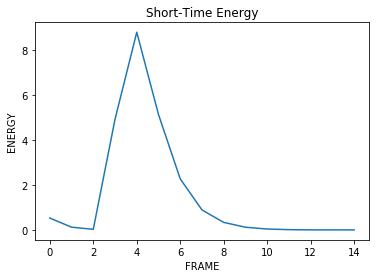

In [101]:
file='./CA4-data/zero_to_nine_Shradha1.wav'

fs, signal1 = read(file)
signal = signal1/max(abs(signal1))  #Scale the audio file

# For a window with sampling frequency fs
window_length = 30  #in ms
sampsPerFrame = int(window_length*fs/1000)
nFrames = int(len(signal)/sampsPerFrame)

STEs=get_STE(signal, nFrames, sampsPerFrame)
plt.plot(STEs[:15])
plt.title('Short-Time Energy')
plt.ylabel('ENERGY')
plt.xlabel('FRAME')

width_phone=18
frame=7
count=0
while(frame<len(STEs)):
    if(STEs[frame]>=0.5):
        count+=1
        sound=signal1[(frame-2)*sampsPerFrame:(frame+width_phone)*sampsPerFrame]
        write('./sounds/test_{}.wav'.format(frame), 8000, sound)
        frame+=27
    else: frame+=1
print(count)

In [336]:
########### Question 2 ###########

file1 ='./cut_dataset/7/digit_7_0_0.wav'

fs, digit1 = read(file1)
digit = digit1/max(abs(digit1))  #Scale the audio file

features=np.array(feature_extractor(digit))

In [679]:
########### Question 3 ##########
# Creating a codebook with training data
directory = './cut_dataset/'
codebook = np.zeros((10,108*60,13))
for label in range(10):  #Iterate over each digit
    folder = os.path.join(directory,str(label)+'/')
    i=0
    for file in os.listdir(folder):
        fs, digit1 = read(folder+file)
        digit = digit1/max(abs(digit1))  #Scale the audio file
        features=np.array(feature_extractor(digit))
        codebook[label,i*60:(i+1)*60,:] = features
        i+=1
    print('done', label)

done 0
done 1
done 2
done 3
done 4
done 5
done 6
done 7
done 8
done 9


In [3]:
# Splits a codebook with all data into training and test data
# Test ranges from 0 to 27
def split_codebook(codebook, test): 
    train_codebook = np.zeros((codebook.shape[0],codebook.shape[1]-(4*60),codebook.shape[2]))
    testset = np.zeros((codebook.shape[0],4*60,codebook.shape[2]))
    for label in range(10):  #Iterate over each digit
        i=0
        j=0
        for count in range(codebook.shape[1]//60):
            if(count < 4*test or count >= 4*test+4): #if does not belong to test set add to codebook
                train_codebook[label,i*60:(i+1)*60,:] = codebook[label,count*60:(count+1)*60,:]
                i+=1
            else: #add to test set
                testset[label,j*60:(j+1)*60,:] = codebook[label,count*60:(count+1)*60,:]
                j+=1             
    return codebook, testset

In [4]:
def predict_with_features(features, vq_cb):
    min_distance=100000000 
    pred=10
    for label in range(vq_cb.shape[0]):  #Iterate overall all digit vector clouds
        d_label=0
        for i in range(features.shape[0]):  #For the ith frame of test sample
            d_min=10000000
            for k in range(vq_cb.shape[1]):  #Compare it with the K vectors per digit
                d = euclidean_distance(features[i],vq_cb[label,k])  #Calculate Euclidean distance
                if(d<d_min):
                    d_min=d
            d_label +=d_min  #Accumulate minimum Euclidean distances for all frames of test sample
        d_label/=60  #Average out 
        if(d_label < min_distance):
            min_distance = d_label
            pred = label
    return pred

For 4 clusters: Accuracy =  68.33333333333333
[[72  1  8 14  2  1  2  1  6  1]
 [ 4 52  2  0  5  3  0  3  0 39]
 [17  3 70  8  7  0  0  0  3  0]
 [14  3  2 75  0  0  0  0  4 10]
 [10  2  3  0 87  3  1  0  2  0]
 [ 0 15  1  0  3 74  0  5  0 10]
 [ 1  0  0  0  0  1 98  0  8  0]
 [ 2  8  0  0  3  1  1 83  2  8]
 [ 7  1  5 17  0  6 21  2 48  1]
 [ 0 16  0  0  0  4  1  8  0 79]]
For 8 clusters: Accuracy =  84.62962962962963
[[ 97   1   1   1   2   0   2   1   2   1]
 [  1  88   0   0   1   7   0   0   0  11]
 [  3   1  94   1   4   2   1   0   2   0]
 [  1   0   0  92   0   0   1   0  10   4]
 [  4   0   5   0  95   4   0   0   0   0]
 [  0   3   0   0   0  93   0   3   0   9]
 [  0   0   1   0   0   0  91   0  16   0]
 [  1   0   0   0   0   1   0 101   0   5]
 [  1   0   2  10   1   1  13   2  78   0]
 [  0   9   0   0   0   6   0   8   0  85]]
For 16 clusters: Accuracy =  93.24074074074075
[[105   0   0   1   1   0   0   0   0   1]
 [  1 102   0   0   0   0   0   0   0   5]
 [  0   1 103

ValueError: x and y must have same first dimension, but have shapes (1,) and (4,)

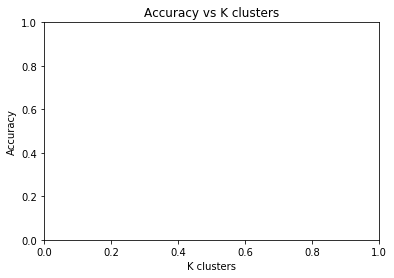

In [640]:
accuracy_list = []
k_list = [4, 8, 16, 64]
for K in k_list:
    pred_list = []
    target_list = []
    for test in range(27):
        cb, testset = split_codebook(codebook, test)
        cb = vq_codebook(cb, K)
        directory = './cut_dataset/'
        for label in range(10):  #Iterate over each digit
            for i in range(4):
                test_features = testset[label, i*60:(i+1)*60:]
                pred = predict_with_features(test_features, cb)
                pred_list.append(pred)
                target_list.append(label)
                total+=1
    accuracy = get_accuracy(target_list, pred_list)
    accuracy_list.append(accuracy)    
    print('For {} clusters:'.format(K), "Accuracy = ", accuracy)
    conf = confusion_matrix(target_list, pred_list)
    print(conf)
    
fig = plt.figure()
plt.title("Accuracy vs K clusters")
plt.xlabel('K clusters')
plt.ylabel('Accuracy')
plt.plot(k_list, accuracy_list)

fig = plt.figure()
plt.title("WER (%) vs K clusters")
plt.xlabel('K clusters')
plt.ylabel('WER')
plt.plot(k_list, list(np.array([100,100,100,100])-np.array(accuracy_list)))

In [5]:
def get_dynamic_features(digit):
    mfcc_features = np.array(feature_extractor(digit))
    dynamic_features = np.zeros((mfcc_features.shape[0], mfcc_features.shape[1]*3))
    dynamic_features[:,:13] = mfcc_features
    dynamic_features[:,13:26] = mfcc_features
    dynamic_features[:,26:39] = mfcc_features
    for j in range(1,12):
        dynamic_features[:,13+j] = (mfcc_features[:,j+1] - mfcc_features[:,j-1])/2.0
    for j in range(2,11):
        dynamic_features[:,26+j] = (mfcc_features[:,j+2] - mfcc_features[:,j-2])/2.0
    return dynamic_features

In [691]:
list(get_dynamic_features(digit))[0]

array([-4.34720408e+03,  2.62285914e+02,  3.65290947e+02, -1.52812312e+02,
       -9.91910371e+00, -2.92630612e+01,  1.04181838e+02, -1.22499058e+02,
       -1.33316825e+01,  4.30639197e+01,  4.73985634e+01, -7.05632287e+01,
       -1.16167803e+01, -4.34720408e+03,  2.35624751e+03, -2.07549113e+02,
       -1.87605026e+02,  6.17746253e+01,  5.70504706e+01, -4.66179986e+01,
       -5.87567600e+01,  8.27814890e+01,  3.03651230e+01, -5.68135742e+01,
       -2.95076719e+01, -1.16167803e+01, -4.34720408e+03,  2.62285914e+02,
        2.16864249e+03, -1.45774488e+02, -1.30554555e+02,  1.51566267e+01,
       -1.70628942e+00,  3.61634904e+01, -2.83916370e+01,  2.59679148e+01,
        8.57451108e-01, -7.05632287e+01, -1.16167803e+01])

In [693]:
####### Question 4 ############
# Creating a codebook with 39 features + Pre Emphasis
directory = './cut_dataset/'
codebook_1 = np.zeros((10,108*60,39))
for label in range(10):  #Iterate over each digit
    folder = os.path.join(directory,str(label)+'/')
    i=0
    for file in os.listdir(folder):
        fs, digit1 = read(folder+file)
        digit = digit1/max(abs(digit1))  #Scale the audio file
        digit = pre_emphasis(digit, 0.9)  #Pre emphasis of 0.9 alpha
        features=get_dynamic_features(digit)
        codebook_1[label,i*60:(i+1)*60,:] = features
        i+=1
    print('done', label)

pred_list = []
target_list = []
for test in range(27):
    cb, testset = split_codebook(codebook_1, test)
    cb = vq_codebook(cb, 64)
    directory = './cut_dataset/'
    for label in range(10):  #Iterate over each digit
        for i in range(4):
            test_features = testset[label, i*60:(i+1)*60:]
            pred = predict_with_features(test_features, cb)
            pred_list.append(pred)
            target_list.append(label)
            total+=1
accuracy = get_accuracy(target_list, pred_list)  
print("\nAccuracy = ", accuracy)
conf = confusion_matrix(target_list, pred_list)
print(conf)

done 0
done 1
done 2
done 3
done 4
done 5
done 6
done 7
done 8
done 9

Accuracy =  98.88888888888889
[[107   0   0   0   1   0   0   0   0   0]
 [  1 107   0   0   0   0   0   0   0   0]
 [  0   0 108   0   0   0   0   0   0   0]
 [  0   0   0 107   0   0   0   0   1   0]
 [  4   0   0   0 104   0   0   0   0   0]
 [  0   0   0   0   0 108   0   0   0   0]
 [  0   0   0   0   0   0 108   0   0   0]
 [  1   0   0   0   0   0   0 107   0   0]
 [  0   0   0   2   0   0   1   0 105   0]
 [  0   0   0   0   0   1   0   0   0 107]]


In [685]:
# Creating a codebook with 13 features on PRE EMPHASISED SOUND
directory = './cut_dataset/'
codebook_2 = np.zeros((10,108*60,13))
for label in range(10):  #Iterate over each digit
    folder = os.path.join(directory,str(label)+'/')
    i=0
    for file in os.listdir(folder):
        fs, digit1 = read(folder+file)
        digit = digit1/max(abs(digit1))  #Scale the audio file
        digit = pre_emphasis(digit, 0.9)  #Pre emphasis of 0.9 alpha
        features=np.array(feature_extractor(digit))
        codebook_2[label,i*60:(i+1)*60,:] = features
        i+=1
    print('done', label)

pred_list = []
target_list = []
for test in range(27):
    cb, testset = split_codebook(codebook_2, test)
    cb = vq_codebook(cb, 64)
    directory = './cut_dataset/'
    for label in range(10):  #Iterate over each digit
        for i in range(4):
            test_features = testset[label, i*60:(i+1)*60:]
            pred = predict_with_features(test_features, cb)
            pred_list.append(pred)
            target_list.append(label)
            total+=1
accuracy = get_accuracy(target_list, pred_list)  
print("\nAccuracy = ", accuracy)
conf = confusion_matrix(target_list, pred_list)
print(conf)

done 0
done 1
done 2
done 3
done 4
done 5
done 6
done 7
done 8
done 9

Accuracy =  98.70370370370371
[[107   0   0   0   1   0   0   0   0   0]
 [  0 108   0   0   0   0   0   0   0   0]
 [  0   0 108   0   0   0   0   0   0   0]
 [  0   0   0 107   0   0   0   0   1   0]
 [  3   0   0   0 105   0   0   0   0   0]
 [  0   0   0   0   0 108   0   0   0   0]
 [  0   0   0   1   0   0 106   0   1   0]
 [  0   0   0   0   0   0   0 108   0   0]
 [  0   0   0   2   0   0   2   0 104   0]
 [  0   2   0   0   0   1   0   0   0 105]]


In [698]:
# Creating a codebook with 13 dynamic features (delta delta mfccs)
directory = './cut_dataset/'
codebook_3 = np.zeros((10,108*60,13))
for label in range(10):  #Iterate over each digit
    folder = os.path.join(directory,str(label)+'/')
    i=0
    for file in os.listdir(folder):
        fs, digit1 = read(folder+file)
        digit = digit1/max(abs(digit1))  #Scale the audio file
        features=get_dynamic_features(digit)[:,26:39]
        codebook_3[label,i*60:(i+1)*60,:] = features
        i+=1
    print('done', label)

pred_list = []
target_list = []
for test in range(27):
    cb, testset = split_codebook(codebook_3, test)
    cb = vq_codebook(cb, 64)
    directory = './cut_dataset/'
    for label in range(10):  #Iterate over each digit
        for i in range(4):
            test_features = testset[label, i*60:(i+1)*60:]
            pred = predict_with_features(test_features, cb)
            pred_list.append(pred)
            target_list.append(label)
            total+=1
accuracy = get_accuracy(target_list, pred_list)  
print("\nAccuracy = ", accuracy)
conf = confusion_matrix(target_list, pred_list)
print(conf)

done 0
done 1
done 2
done 3
done 4
done 5
done 6
done 7
done 8
done 9

Accuracy =  96.11111111111111
[[105   0   1   0   1   1   0   0   0   0]
 [  0 100   0   0   0   2   0   0   0   6]
 [  2   0 105   1   0   0   0   0   0   0]
 [  0   0   0 108   0   0   0   0   0   0]
 [  4   0   0   0 104   0   0   0   0   0]
 [  0   0   0   0   0 106   0   0   0   2]
 [  0   0   0   1   0   0 103   0   4   0]
 [  0   0   0   0   0   1   0 106   0   1]
 [  0   0   0   3   0   0   3   0 102   0]
 [  0   3   0   0   0   3   0   3   0  99]]


In [703]:
#### Gender based separation in data

directory = './Digits_female/'
done=0
for file in os.listdir(directory):
    fs, signal1 = read(directory+file)
    signal = signal1/max(abs(signal1))  #Scale the audio file

    # For a window with sampling frequency fs
    window_length = 30  #in ms
    sampsPerFrame = int(window_length*fs/1000)
    nFrames = int(len(signal)/sampsPerFrame)
    
    # Get the STE of the input signal
    STEs=get_STE(signal, nFrames, sampsPerFrame)
    
    # Cut the digits and save in the respective folder
    end_pointer(signal1, STEs, done)
    
    done+=1
    print("Done: ", done, file)

20
Done:  1 zero_to_nine_Ankita1.wav
20
Done:  2 zero_to_nine_Ankita2.wav
20
Done:  3 zero_to_nine_charvi01.wav
20
Done:  4 zero_to_nine_charvi02.wav
20
Done:  5 zero_to_nine_Kamini1.wav
20
Done:  6 zero_to_nine_Kamini2.wav
20
Done:  7 zero_to_nine_lakshmi01.wav
20
Done:  8 zero_to_nine_lakshmi02.wav
20
Done:  9 zero_to_nine_Mansi1.wav
20
Done:  10 zero_to_nine_Mansi2.wav
20
Done:  11 zero_to_nine_Pragya1.wav
20
Done:  12 zero_to_nine_Pragya2.wav
20
Done:  13 zero_to_nine_Prarthana1.wav
20
Done:  14 zero_to_nine_Prarthana2.wav
20
Done:  15 zero_to_nine_Reshma1.wav
20
Done:  16 zero_to_nine_Reshma2.wav
20
Done:  17 zero_to_nine_Richa1.wav
20
Done:  18 zero_to_nine_Richa2.wav
20
Done:  19 zero_to_nine_Shradha1.wav
20
Done:  20 zero_to_nine_Shradha2.wav


In [705]:
directory = './cut_gender_separated_data/Male'
codebook_male = np.zeros((10,68*60,13))
for label in range(10):  #Iterate over each digit
    folder = os.path.join(directory,str(label)+'/')
    i=0
    for file in os.listdir(folder):
        fs, digit1 = read(folder+file)
        digit = digit1/max(abs(digit1))  #Scale the audio file
        features=np.array(feature_extractor(digit))
        codebook_male[label,i*60:(i+1)*60,:] = features
        i+=1
    print('done', label)

directory = './cut_gender_separated_data/Female'
codebook_female = np.zeros((10,40*60,13))
for label in range(10):  #Iterate over each digit
    folder = os.path.join(directory,str(label)+'/')
    i=0
    for file in os.listdir(folder):
        fs, digit1 = read(folder+file)
        digit = digit1/max(abs(digit1))  #Scale the audio file
        features=np.array(feature_extractor(digit))
        codebook_female[label,i*60:(i+1)*60,:] = features
        i+=1
    print('done', label)

done 0
done 1
done 2
done 3
done 4
done 5
done 6
done 7
done 8
done 9
done 0
done 1
done 2
done 3
done 4
done 5
done 6
done 7
done 8
done 9
Training data: Males, Testing data: Males



ValueError: could not broadcast input array from shape (0,13) into shape (60,13)

In [710]:
#### Training data: Males, Testing data: Males ########
print('Training data: Males, Testing data: Males\n')
pred_list = []
target_list = []
for test in range(17):
    cb, testset = split_codebook(codebook_male, test)
    cb = vq_codebook(cb, 64)
    directory = './cut_dataset/'
    for label in range(10):  #Iterate over each digit
        for i in range(4):
            test_features = testset[label, i*60:(i+1)*60:]
            pred = predict_with_features(test_features, cb)
            pred_list.append(pred)
            target_list.append(label)
            total+=1
accuracy = get_accuracy(target_list, pred_list)  
print("\nAccuracy = ", accuracy)
conf = confusion_matrix(target_list, pred_list)
print(conf)

#### Training data: Females, Testing data: Females ########
print('\nTraining data: Females, Testing data: Females\n')
pred_list = []
target_list = []
for test in range(10):
    cb, testset = split_codebook(codebook_female, test)
    cb = vq_codebook(cb, 64)
    directory = './cut_dataset/'
    for label in range(10):  #Iterate over each digit
        for i in range(4):
            test_features = testset[label, i*60:(i+1)*60:]
            pred = predict_with_features(test_features, cb)
            pred_list.append(pred)
            target_list.append(label)
            total+=1
accuracy = get_accuracy(target_list, pred_list)  
print("\nAccuracy = ", accuracy)
conf = confusion_matrix(target_list, pred_list)
print(conf)

Training data: Males, Testing data: Males


Accuracy =  99.8529411764706
[[68  0  0  0  0  0  0  0  0  0]
 [ 0 68  0  0  0  0  0  0  0  0]
 [ 1  0 67  0  0  0  0  0  0  0]
 [ 0  0  0 68  0  0  0  0  0  0]
 [ 0  0  0  0 68  0  0  0  0  0]
 [ 0  0  0  0  0 68  0  0  0  0]
 [ 0  0  0  0  0  0 68  0  0  0]
 [ 0  0  0  0  0  0  0 68  0  0]
 [ 0  0  0  0  0  0  0  0 68  0]
 [ 0  0  0  0  0  0  0  0  0 68]]

Training data: Females, Testing data: Females


Accuracy =  100.0
[[40  0  0  0  0  0  0  0  0  0]
 [ 0 40  0  0  0  0  0  0  0  0]
 [ 0  0 40  0  0  0  0  0  0  0]
 [ 0  0  0 40  0  0  0  0  0  0]
 [ 0  0  0  0 40  0  0  0  0  0]
 [ 0  0  0  0  0 40  0  0  0  0]
 [ 0  0  0  0  0  0 40  0  0  0]
 [ 0  0  0  0  0  0  0 40  0  0]
 [ 0  0  0  0  0  0  0  0 40  0]
 [ 0  0  0  0  0  0  0  0  0 40]]


In [711]:
#### Training data: Males, Testing data: Females ########
print('Training data: Males, Testing data: Females\n')
pred_list = []
target_list = []
for test in range(10):
    _, testset = split_codebook(codebook_female, test)
    cb = codebook_male
    cb = vq_codebook(cb, 64)
    directory = './cut_dataset/'
    for label in range(10):  #Iterate over each digit
        for i in range(4):
            test_features = testset[label, i*60:(i+1)*60:]
            pred = predict_with_features(test_features, cb)
            pred_list.append(pred)
            target_list.append(label)
            total+=1
accuracy = get_accuracy(target_list, pred_list)  
print("\nAccuracy = ", accuracy)
conf = confusion_matrix(target_list, pred_list)
print(conf)

#### Training data: Females, Testing data: Males ########
print('Training data: Females, Testing data: Males\n')
pred_list = []
target_list = []
for test in range(17):
    _, testset = split_codebook(codebook_male, test)
    cb = codebook_female
    cb = vq_codebook(cb, 64)
    directory = './cut_dataset/'
    for label in range(10):  #Iterate over each digit
        for i in range(4):
            test_features = testset[label, i*60:(i+1)*60:]
            pred = predict_with_features(test_features, cb)
            pred_list.append(pred)
            target_list.append(label)
            total+=1
accuracy = get_accuracy(target_list, pred_list)  
print("\nAccuracy = ", accuracy)
conf = confusion_matrix(target_list, pred_list)
print(conf)

Training data: Males, Testing data: Females


Accuracy =  53.25
[[23  6  0  0  0  3  0  6  0  2]
 [ 0 18  0  0  0  0  0  0  0 22]
 [ 5  0 26  0  9  0  0  0  0  0]
 [ 0  0  0  8  0  0  0  1 23  8]
 [ 6  6  0  0 28  0  0  0  0  0]
 [ 0  2  0  0  0 10  0  0  0 28]
 [ 0  0  1  0  0  0 14  0 25  0]
 [ 0  1  0  0  0  1  0 10  0 28]
 [ 0  0  0  0  0  1  0  1 38  0]
 [ 0  2  0  0  0  0  0  0  0 38]]
Training data: Females, Testing data: Males


Accuracy =  63.8235294117647
[[46  2  5  7  5  1  0  2  0  0]
 [ 4 44  0  0  8  4  0  6  0  2]
 [ 3  3 56  0  1  0  1  1  0  3]
 [ 4  0  3 55  0  0  1  5  0  0]
 [ 0  2 15  0 49  2  0  0  0  0]
 [ 1  8  0  0  1 46  0 12  0  0]
 [ 3  0  0  0  3  0 62  0  0  0]
 [ 2  0  0  0  5  0  0 61  0  0]
 [ 4  0  2 38  0  0 15  0  9  0]
 [ 0 36  0  0  0  5  1 20  0  6]]


In [106]:
def distance_cost_plot(distances):
    im = plt.imshow(distances, interpolation='nearest', cmap='Blues') 
    plt.gca().invert_yaxis()
    plt.xlabel("Template Features")
    plt.ylabel("Test Features")
    plt.grid()
    plt.colorbar();

In [46]:
def path_cost(x, y, accumulated_cost, distances):
    #Maps frames between x and y for minimum cost
    path = [[len(x)-1, len(y)-1]]
    cost = 0
    i = len(x)-1
    j = len(y)-1
    while i>0 and j>0:
        if i==0:
            j = j - 1
        elif j==0:
            i = i - 1
        else:
            if accumulated_cost[i-1, j] == min(accumulated_cost[i-1, j-1],
                                               accumulated_cost[i-1, j], accumulated_cost[i, j-1]):
                i = i - 1
            if accumulated_cost[i, j-1] == min(accumulated_cost[i-1, j-1],
                                               accumulated_cost[i-1, j], accumulated_cost[i, j-1]):
                j = j-1
            else:
                i = i - 1
                j = j - 1
        path.append([i, j])
    path.append([0,0])
    for [x, y] in path:
        cost = cost + distances[x, y]
    return path, cost

In [101]:
def dynamic_time_warping(template_features, test_features):
    x=template_features
    y=test_features
    distances = np.zeros((len(x), len(y)))
    
    #Create a distance matrix for all combinations of test and template frames
    for i in range(len(x)):
        for j in range(len(y)):
            distances[i,j] = euclidean_distance(x[i],y[j])
    
    #Develop the accumulated cost array i.e. the minimum total cost to get to a point x,y
    accumulated_cost = np.zeros((len(x), len(y)))
    accumulated_cost[0,0] = distances[0,0]
    for i in range(1, len(y)):
        accumulated_cost[0,i] = distances[0,i] + accumulated_cost[0, i-1] 
    for i in range(1, len(x)):
        accumulated_cost[i,0] = distances[i, 0] + accumulated_cost[i-1, 0]    
    for i in range(1, len(x)):
        for j in range(1, len(y)):
            accumulated_cost[i, j] = min(accumulated_cost[i-1, j-1],
                                         accumulated_cost[i-1, j], accumulated_cost[i, j-1]) + distances[i, j]
            
    path, cost = path_cost(x, y, accumulated_cost, distances)      
    
#     path_x = [point[0] for point in path]
#     path_y = [point[1] for point in path]

#     distance_cost_plot(accumulated_cost)
#     plt.plot(path_x, path_y, 'r-')
    
    return path, cost

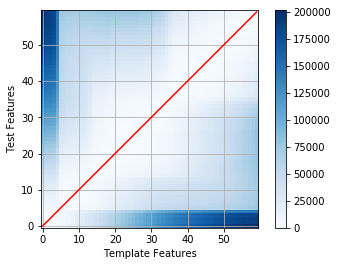

In [100]:
file1 ='./cut_dataset/1/digit_1_37_1.wav'
file2 ='./cut_dataset/1/digit_1_37_1.wav'
_, digit1 = read(file1)
_, digit2 = read(file2)

template = np.array(feature_extractor(digit1/max(abs(digit1))))
test = np.array(feature_extractor(digit2/max(abs(digit2))))

path,cost= dynamic_time_warping(template, test)

In [67]:
print(cost)
print(len(path))
path

15883.034585182671
57


[[59, 59],
 [58, 58],
 [56, 57],
 [54, 56],
 [52, 55],
 [50, 54],
 [48, 53],
 [46, 52],
 [45, 51],
 [45, 50],
 [45, 49],
 [44, 48],
 [43, 47],
 [42, 46],
 [41, 45],
 [40, 44],
 [39, 43],
 [39, 42],
 [38, 41],
 [37, 40],
 [36, 39],
 [35, 38],
 [33, 37],
 [31, 36],
 [29, 35],
 [28, 34],
 [27, 33],
 [26, 32],
 [25, 31],
 [24, 30],
 [23, 29],
 [22, 28],
 [21, 27],
 [20, 26],
 [19, 25],
 [18, 24],
 [17, 23],
 [17, 22],
 [16, 21],
 [15, 20],
 [14, 19],
 [13, 18],
 [12, 17],
 [11, 16],
 [10, 15],
 [9, 14],
 [8, 13],
 [8, 12],
 [7, 11],
 [7, 10],
 [7, 9],
 [6, 8],
 [5, 7],
 [4, 6],
 [2, 5],
 [0, 4],
 [0, 0]]

In [104]:
def predict_with_DTW(test_features, cb):
    min_distance=100000000 
    pred=10
    for label in range(cb.shape[0]):  #Iterate overall all digit vector clouds
        d_label=0
        d_min=10000000
        for i in range(3):  #Compare with 3 random template samples from the class
            n = random.randint(0,103)
            template_features = cb[label, n*60:(n+1)*60,:]
            _, cost = dynamic_time_warping(template_features, test_features) 
            if(cost<d_min):
                d_min = cost
        d_label = d_min
        if(d_label < min_distance):
            min_distance = d_label
            pred = label
    return pred

In [89]:
directory = './cut_dataset/'
codebook_dtw = np.zeros((10,108*60,13))
for label in range(10):  #Iterate over each digit
    folder = os.path.join(directory,str(label)+'/')
    i=0
    for file in os.listdir(folder):
        fs, digit1 = read(folder+file)
        digit = digit1/max(abs(digit1))  #Scale the audio file
        features=np.array(feature_extractor(digit))
        codebook_dtw[label,i*60:(i+1)*60,:] = features
        i+=1
    print('done', label)

done 0
done 1
done 2
done 3
done 4
done 5
done 6
done 7
done 8
done 9


In [105]:
pred_list = []
target_list = []
for test in range(27):
    print(test)
    cb, testset = split_codebook(codebook_dtw, test)
    for label in range(10):  #Iterate over each digit
        print(label)
        for i in range(4):  #Size of testset
            test_features = testset[label, i*60:(i+1)*60:]
            pred = predict_with_DTW(test_features, cb)
            pred_list.append(pred)
            target_list.append(label)
accuracy = get_accuracy(target_list, pred_list)  
print("\nAccuracy = ", accuracy)
conf = confusion_matrix(target_list, pred_list)
print(conf)

0
0
1
2
3
4
5
6
7
8
9
1
0
1
2
3
4
5
6
7
8
9
2
0
1
2
3
4
5
6
7
8
9
3
0
1
2
3
4
5
6
7
8
9
4
0
1
2
3
4
5
6
7
8
9
5
0
1
2
3
4
5
6
7
8
9
6
0
1
2
3
4
5
6
7
8
9
7
0
1
2
3
4
5
6
7
8
9
8
0
1
2
3
4
5
6
7
8
9
9
0
1
2
3
4
5
6
7
8
9
10
0
1
2
3
4
5
6
7
8
9
11
0
1
2
3
4
5
6
7
8
9
12
0
1
2
3
4
5
6
7
8
9
13
0
1
2
3
4
5
6
7
8
9
14
0
1
2
3
4
5
6
7
8
9
15
0
1
2
3
4
5
6
7
8
9
16
0
1
2
3
4
5
6
7
8
9
17
0
1
2
3
4
5
6
7
8
9
18
0
1
2
3
4
5
6
7
8
9
19
0
1
2
3
4
5
6
7
8
9
20
0
1
2
3
4
5
6
7
8
9
21
0
1
2
3
4
5
6
7
8
9
22
0
1
2
3
4
5
6
7
8
9
23
0
1
2
3
4
5
6
7
8
9
24
0
1
2
3
4
5
6
7
8
9
25
0
1
2
3
4
5
6
7
8
9
26
0
1
2
3
4
5
6
7
8
9

Accuracy =  69.44444444444444
[[89  0  4  2  1  1  0  3  3  5]
 [ 0 70  0  1  0  8  0  6  0 23]
 [ 1  1 75 16  7  0  1  0  7  0]
 [ 3  1 11 71  0  1  1  5 13  2]
 [ 9  4 13  3 65  5  0  2  6  1]
 [ 1 15  2  1  1 64  0  5  0 19]
 [ 0  0  0  1  2  2 92  1  9  1]
 [ 3  4  1  2  0  4  0 82  2 10]
 [ 0  4 10  5  3  0 12  2 71  1]
 [ 0 20  3  0  0  7  0  7  0 71]]
